# Hello LTR!

Fire up an elastic server with the LTR plugin installed and run thru the cells below to get started with Learning-to-Rank. These notebooks we'll use in this training have something of an ltr client library, and a starting point for demonstrating several important learning to rank capabilities.

This notebook will document many of the important pieces so you can reuse them in future training sessions

### The library: ltr 

This is a Python library, located at the top level of the repository in `hello-ltr/ltr/`. It contains helper functions used through out the notebooks.

If you want to edit the source code, make sure you are running the Jupyter Notebook server locally and not from a Docker container.

In [1]:
import ltr
import ltr.client as client
import ltr.index as index
import ltr.helpers.movies as helpers

### Download some requirements

Several requirements/datasets are stored in online, these include various training data sets, the data sets, and tools. You'll only need to do this once. But if you lose the data, you can repeat this command if needed.

In [2]:
corpus = 'http://es-learn-to-rank.labs.o19s.com/tmdb.json'

ltr.download([corpus], dest='data/')

data/tmdb.json already exists


### Use the Elastic client

Two LTR clients exist in this code, an ElasticClient and a SolrClient. The workflow for doing Learning to Rank is the same in both search engines

In [3]:
client = client.ElasticClient()

### Index Movies

In these demos, we'll use [TheMovieDB](http://themoviedb.org) alongside some supporting assets from places like movielens.

When we reindex, we'll use `ltr.index.rebuild` which deletes and recreates the index, with a few hooks to help us enrich the underlying data or modify the search engine configuration for feature engineering.

In [4]:
movies = helpers.indexable_movies(movies='data/tmdb.json')

index.rebuild(client, index='tmdb', doc_src=movies)

Index tmdb already exists. Use `force = True` to delete and recreate


### Configure Learning to Rank

We'll discuss the feature sets a bit more. You can think of them as a series of queries that will be stored and executed before we need to train a model. 

`setup` is our function for preparing learning to rank to optimize search using a set of features. In this stock demo, we just have one feature, the year of the movie's release.

In [5]:
# wipes out any existing LTR models/feature sets in the tmdb index
client.reset_ltr(index='tmdb')

Removed Default LTR feature store [Status: 200]
Initialize Default LTR feature store [Status: 200]


In [6]:
# A feature set as a tuple, which looks a lot like JSON
feature_set = {
    "featureset": {
        "features": [
            {
                "name": "release_year",
                "params": [],
                "template": {
                    "function_score": {
                        "field_value_factor": {
                            "field": "release_year",
                            "missing": 2000
                        },
                        "query": { "match_all": {} }
                    }
                }
            }
        ]
    }
}

feature_set

{'featureset': {'features': [{'name': 'release_year',
    'params': [],
    'template': {'function_score': {'field_value_factor': {'field': 'release_year',
       'missing': 2000},
      'query': {'match_all': {}}}}}]}}

In [7]:
# pushes the feature set to the tmdb index's LTR store (a hidden index)
client.create_featureset(index='tmdb', name='release', ftr_config=feature_set)

Create release feature set [Status: 201]


## Is this thing on?

Before we dive into all the pieces, with a real training set, we'll try out two examples of models. One that always prefers newer movies. And another that always prefers older movies. If you're curious you can opet `classic-training.txt` and `latest-training.txt` after running this to see what the training set looks like. 

### Generate some judgement data

This will write out judgment data to a file path.

Look at the source code in `ltr/years_as_ratings.py` to see what assumptions are being made in this synthetic judgment. What assumptions do you make in your judgment process?

In [8]:
from ltr.years_as_ratings import synthesize

synthesize(
    client, 
    featureSet='release', # must match the name set in client.create_featureset(...)
    classicTrainingSetOut='data/classic-training.txt',
    latestTrainingSetOut='data/latest-training.txt'
)

Generating 'latest' biased judgments:
Generating 'recent' biased judgments:


### Format the training data as two arrays of Judgement objects

This step is in preparation for passing the traning data into Ranklib.

In [9]:
import ltr.judgments as judge

classic_training_set = [j for j in judge.judgments_from_file(open('data/classic-training.txt'))]
latest_training_set = [j for j in judge.judgments_from_file(open('data/latest-training.txt'))]

Recognizing 1 queries in: data/classic-training.txt
Recognizing 1 queries in: data/latest-training.txt


#### Why not DataFrames?

While Ranklib requires data in a certain format. You might want to explore the judgments and feature values as if they were DataFrames. So we have helper functions for converting them.

In [10]:
classic_df = judge.judgments_to_df(classic_training_set)
classic_df = judge.judgments_df_to_long(classic_df)
classic_df
# this isn't part of the process, but useful if you want to explore the data

,uid,feature_id,docId,grade,keywords,qid,features
0,1_374430,0,374430,0,,1,2014.0
1,1_19404,0,19404,1,,1,1995.0
2,1_278,0,278,1,,1,1994.0
3,1_372058,0,372058,0,,1,2016.0
4,1_238,0,238,2,,1,1972.0
...,...,...,...,...,...,...,...
995,1_967,0,967,3,,1,1960.0
996,1_13008,0,13008,1,,1,2007.0
997,1_4951,0,4951,1,,1,1999.0
998,1_228205,0,228205,0,,1,2015.0


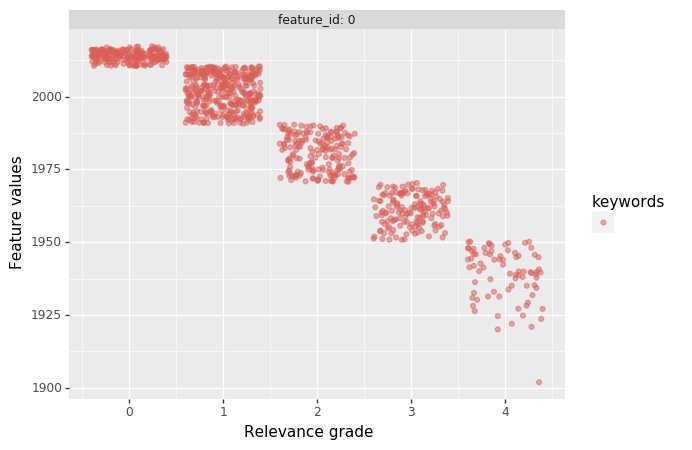

{<ggplot: (296705895)>}

In [12]:
# maybe you want to plot your features?
import ltr.p9_plots as plots

plots.plot_features(classic_df)

### Train and Submit

We'll train a lot of models in this class! Our ltr library has a `train` method that wraps a tool called `Ranklib` (more on Ranklib later), allows you to pass the most common commands to Ranklib, stores a model in the search engine, and then returns diagnostic output that's worth inspecting. 

For now we'll just train using the generated training set, and store two models `latest` and `classic`.


In [13]:
from ltr.ranklib import train

train(client, training_set=latest_training_set, 
      index='tmdb', featureSet='release', modelName='latest')

/var/folders/7_/cvjz84n54vx7zv_pw3gmdqr00000gn/T/RankyMcRankFace.jar already exists
Running java -jar /var/folders/7_/cvjz84n54vx7zv_pw3gmdqr00000gn/T/RankyMcRankFace.jar -ranker 6 -shrinkage 0.1 -metric2t DCG@10 -tree 50 -bag 1 -leaf 10 -frate 1.0 -srate 1.0 -train /var/folders/7_/cvjz84n54vx7zv_pw3gmdqr00000gn/T/training.txt -save data/latest_model.txt 
Delete model latest: 404
Created Model latest [Status: 201]
Model saved


Now train another model based on the 'classsic' movie judgments.

In [14]:
train(client, training_set=classic_training_set, 
      index='tmdb', featureSet='release', modelName='classic')

/var/folders/7_/cvjz84n54vx7zv_pw3gmdqr00000gn/T/RankyMcRankFace.jar already exists
Running java -jar /var/folders/7_/cvjz84n54vx7zv_pw3gmdqr00000gn/T/RankyMcRankFace.jar -ranker 6 -shrinkage 0.1 -metric2t DCG@10 -tree 50 -bag 1 -leaf 10 -frate 1.0 -srate 1.0 -train /var/folders/7_/cvjz84n54vx7zv_pw3gmdqr00000gn/T/training.txt -save data/classic_model.txt 
Delete model classic: 404
Created Model classic [Status: 201]
Model saved


### Ben Affleck vs Adam West
If we search for `batman`, how do the results compare?  Since the `classic` model prefered old movies it has old movies in the top position, and the opposite is true for the `latest` model.  To continue learning LTR, brainstorm more features and generate some real judgments for real queries.

In [ ]:
import ltr.release_date_plot as rdp
rdp.plot(client, 'batman')

### See top 12 results for both models

Looking at the `classic` model first.

In [ ]:
import pandas as pd
classic_results = rdp.search(client, 'batman', 'classic')
pd.json_normalize(classic_results)[['id', 'title', 'release_year', 'score']].head(12)

And then the `latest` model.

In [ ]:
latest_results = rdp.search(client, 'batman', 'latest')
pd.json_normalize(latest_results)[['id', 'title', 'release_year', 'score']].head(12)